In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Factor models

Let $r_t^i$ be an asset excess return over the risk-free rate

Let $f_t$ be a traded factor, for example the excess returns on the market portfolio

Then we can write

$$r_t^i=b_{i}f_t+u_{i,t}$$

where $b_{i}$ is asset $i$ exposure to the factor

We can always write things that way--it is just a statistical decomposition

1. It can be useful for measuring risk if
    - The risk $u_{i,t}$ is specific to asset $i$ and uncorrelated with other assets 

2. It can be useful for measuring expected returns if
    - The risk $u_{i,t}$ has no premium, i.e., $E[u_{i,t}]=0$
    - The premium of asset $i$ comes exclusively from the exposure to the factor $f$

We will call the first a factor model of risk, and the second a factor model of expected returns

- Which one of the two is the CAPM?
- Which one of the two is the APT?
- Which one of the two is the market model?
- What is the difference between the CAPM and the market model?

## A Single-Factor Risk Model

We now focus on the first case. The assumption that $u_{i,t}$ are uncorrelated across assets is never really satisfied

But it can be achieved approximately

We will see how we can compute covariance matrixes easily under such an assumption

first we will do so using a single factor

In this case the assumption is very bad...and not even close to holding for most assets...but will allow us to get the intuition

We will then learn how to do it with many factors as is standard in the industry

I will add an intercept to make explicit that I am not making any assumption about how the means of the asset and the factor are related



$$r_t^i=a_i+b_{i}f_t+u_{i,t}$$

- $r_t^i$ is the the excess return of asset i over the risk-free rate
- $b_i$ is the exposure or sensitivity of asset $i$ to the factor
- $f_t$ is the excess return of the factor
- non-factor component of the asset return of asset $i$. Assumed to uncorrelated between any two assets

Now this is just a regression!

We have that

$$Var(r_t^i)=b_i^2Var(f_t)+var(u_{i,t})$$


This gives us a nice decomposition of risk

- the risk component that is driven by the common factor
- the asset specific comment


Now if our assumption holds, $cov(u_{i,t},u_{j,t})=0$

Then 

$$Cov(r_t^i,r_t^j)=Cov(a_i+b_{i}f_t+u_{i,t},a_j+b_{j}f_t+u_{j,t})=b_ib_jVar(f_t)$$

And the covariance matrix is simply


$$
\left[\begin{array}{cc}
b_i^2+ var(u_{i,t}) & b_ib_j \\
b_ib_j &  b_j^2 +var(u_{j,t})
\end{array}\right]$$

We see that now for N assets we only need to estimate N factor exposures, N asset specific volatilities , and the factor volatility

>$2N+1$ vs $(N^2-N)/2+N$


That is a huge difference


Suppose we have many assets, all respecting this factor model. Say $R_t$ is the big N by 1 vector of excess return $[r_{1,t},r_{2,t},...]$ for all these assets

$$R_t=bf_t+U_t$$

where $b$ is also a N by 1 vector of exposures $[b_1,b_2,...b_N]$  and $u_t$ is the N by 1 vector of shocks 


Then their variance-covariance matrix is simply


$$Var(R_t)=b @ b' Var(f_t)+ Var(U_t)$$



### Application: Market model






In [11]:
from datetime import datetime

# Create a date parser function that will allow pandas to read the dates in the format we have them
date_parser = lambda x: datetime.strptime(x, "%Y%m")
# our 50 stock returns data

url = "https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/Retuns50stocks.csv"

# Use pd.read_csv with the date_parser
df  = pd.read_csv(url, parse_dates=['date'], date_parser=date_parser)
# Set the date column as the index

# first, create the DataFrame
df.set_index("date",inplace=True)
# put the returns in percentage format
df=df/100
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2000-01-01 to 2014-12-01
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CTL     180 non-null    float64
 1   T       180 non-null    float64
 2   CSCO    180 non-null    float64
 3   FCX     180 non-null    float64
 4   XL      180 non-null    float64
 5   IVZ     180 non-null    float64
 6   AMT     180 non-null    float64
 7   WHR     180 non-null    float64
 8   IR      180 non-null    float64
 9   WFT     180 non-null    float64
 10  YUM     180 non-null    float64
 11  CVS     180 non-null    float64
 12  GD      180 non-null    float64
 13  TYC     180 non-null    float64
 14  EL      180 non-null    float64
 15  MUR     180 non-null    float64
 16  CTAS    180 non-null    float64
 17  CBSA    180 non-null    float64
 18  SNV     180 non-null    float64
 19  CAM     180 non-null    float64
 20  DLTR    180 non-null    float64
 21  CAH     180 non-null

In [21]:
# load regression library
import statsmodels.api as sm
# add a constant to the independent variable
x= sm.add_constant(df['Market'])
# set the dependent variable to be the 'CTL' return
y= df['CTL']
# run the regression
results= sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CTL   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     36.81
Date:                Mon, 29 Jan 2024   Prob (F-statistic):           7.62e-09
Time:                        18:02:15   Log-Likelihood:                 214.56
No. Observations:                 180   AIC:                            -425.1
Df Residuals:                     178   BIC:                            -418.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.006      0.340      0.734      -0.009       0.013
Market         0.7269      0.120      6.068      0.000       0.491       0.963
==============================================================================
Omnibus:                       43.729   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              394.038
Skew:                           0.524   Prob(JB):                     2.73e-86
Kurtosis:                      10.172   Cond. No.                         21.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation:

The coefficient on the market estimates the exposure $b_{CTL}$. It is 0.72 and well estimate

- we see that the standard errors allow us to reject both zero (easy) and one (not as easy simnce the typical stock must have a beta of 1)

We see that the R-squared is 17% so the asset specific risk is sizable

* what fraction of CTL risk is due to the factor?

* how large is the non-factor component?


In [13]:
# to get the residual volatility, we need to get the residuals and compute it's volatility
u= results.resid
print(u.std()*12**0.5)


0.25520301676928053


Lets now estimate the covariance matrix of these 50 stocks using this single-factor model

1. Run regression stock by stock
1. save betas, save residual variance
1. Use formula to construct variance matrix

In [24]:
df.columns[:-1]

Index(['CTL', 'T', 'CSCO', 'FCX', 'XL', 'IVZ', 'AMT', 'WHR', 'IR', 'WFT',
       'YUM', 'CVS', 'GD', 'TYC', 'EL', 'MUR', 'CTAS', 'CBSA', 'SNV', 'CAM',
       'DLTR', 'CAH', 'DTE', 'SSP', 'PSA', 'EXC', 'TKR', 'CMA', 'ORCL', 'MS',
       'RSG', 'ACAS', 'AGN', 'MMM', 'ETFC', 'CAR', 'MDR', 'NOV', 'PCH', 'BAX',
       'JCI', 'SWK', 'DVN', 'TMO', 'PEP', 'LNC', 'EMR', 'MLM', 'CCI', 'NU'],
      dtype='object')

In [48]:
Results=pd.DataFrame(index=df.columns[:-1],columns=['Beta','VarU'],dtype=float)
Factor=df['Market']
Assets=df.drop('Market',axis=1)
x= sm.add_constant(Factor)
for stocki in Assets.columns:
# set the dependent variable to be the 'CTL' return
    y= Assets[stocki]
    # run the regression
    results= sm.OLS(y,x).fit()
    Results.loc[stocki,'Beta']=results.params[1]
    Results.loc[stocki,'VarU']=results.resid.var()

Results

,Beta,VarU
CTL,0.726946,0.005427
T,0.529153,0.004093
CSCO,1.530779,0.006403
FCX,1.569894,0.011742
XL,1.438681,0.011752
IVZ,2.036247,0.004851
AMT,1.352478,0.027122
WHR,1.442238,0.008598
IR,1.461150,0.005901
WFT,1.513599,0.010939


In [78]:
import numpy as np

# Assuming Results is your DataFrame and 'Beta' is your column
beta = Results['Beta'].values
# make sure beta is a column vector (and not di)
beta=beta.reshape(50,1)
# Compute the outer product of the 'Beta' column with itself
beta_matrix = beta @ beta.T
print(beta_matrix)
print(beta_matrix.shape)

# the unsystematic component is a diagonal matrix with the variance of the residuals on the diagonal
CovU=np.diag(Results['VarU'].values)

print(CovU)

print(CovU.shape)

# construct the covariance matrix by adding the systematic and unsystematic components
Cov_F=beta_matrix*Factor.var()+CovU
print(Cov_F)

print(Cov_F.shape)



[[0.52845028 0.38466559 1.11279362 ... 0.63369045 1.21578277 0.32477868]
 [0.38466559 0.28000291 0.81001644 ... 0.46127124 0.88498354 0.23641048]
 [1.11279362 0.81001644 2.34328505 ... 1.334405   2.5601563  0.68390851]
 ...
 [0.63369045 0.46127124 1.334405   ... 0.75988907 1.4579043  0.38945793]
 [1.21578277 0.88498354 2.5601563  ... 1.4579043  2.79709901 0.74720431]
 [0.32477868 0.23641048 0.68390851 ... 0.38945793 0.74720431 0.19960476]]
(50, 50)
[[0.00542738 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00409277 0.         ... 0.         0.         0.        ]
 [0.         0.         0.00640331 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00510028 0.         0.        ]
 [0.         0.         0.         ... 0.         0.01439288 0.        ]
 [0.         0.         0.         ... 0.         0.         0.00218208]]
(50, 50)
[[0.0065499  0.0008171  0.00236376 ... 0.00134607 0.00258253 0.00068989]
 [0.0008171  0.004687

### Application: Minimum-variance investing


* it is mean-variance investing under the assumption that all assets have same expected returns, but uses covariance matrix to minimize risk

 * The idea is that expected returns signals are pure noise so we might as well assume there are no signals and all expected returns are the same
  
 * For example this is behind Minimum volatility investing for example, [https://investor.vanguard.com/mutual-funds/profile/VMVFX]
  
* Assumes all assets have the same expected return

$$Min~ X'Var(R)X~ subject~ to~ \mathbf{1}'X=1$$

The result of this problem is a vector of weights proportional to 

$$W_{minvariance}\propto Var(R)^{-1}\mathbf{1}$$

We then impose the constraint that the weights have to add-up to 1.

$$X_{minvariance}=\frac{Var(R)^{-1}\mathbf{1}}{\mathbf{1}^TVar(R)^{-1}\mathbf{1}}$$

* I use this technique in "hedging-risk factors", a recent academic paper, to construct portfolios with Sharpe-ratios of 0.8 at the yearly horizon, which is very large

> Why this might make sense?

So you see here that the problem is really identical to the mean-variance problem. We simply substituted the vector or Expected returns by a vector of ones.

The end result is that now the solution is the portfolio that minimizes variance while being fully invested as the constraint $\mathbf{1}'W=1$ means $\sum_i^I w_i*1=1$

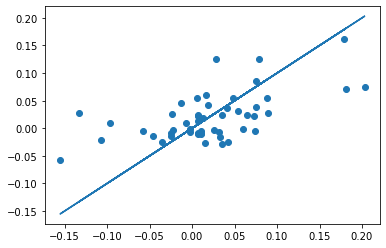

In [82]:
# minimum variance portfolio using the factor-based covariance matrix
ones=np.ones([50,1])
X_minvarFactor=np.linalg.inv(Cov_F)@ ones/(ones.T @np.linalg.inv(Cov_F)@ ones)
# minimum variance portfolio using the unrestricted stock covariance matrix
Cov=Assets.cov()
X_minvar=np.linalg.inv(Cov)@ ones/(ones.T @np.linalg.inv(Cov)@ ones)

# plot the weights against each other
plt.plot(X_minvar,X_minvar)
plt.scatter(X_minvar,X_minvarFactor)



- What do you notice about the weights?
- How do we construct the returns of the strategy?
- What do we need to evaluate performance of the Factor-based approach vs the unrestricted approach?
   - Why can't we simply calculate Sharpe Ratios in the same data?